# Demodulating FM Signals

The aim of this notebook is to show how to demodulate an FM signal and how to choose the parameters of a decimation filter.

This notebook does not involve manipulating the AD9361 device. Rather, it uses a prerecorded sample for reproducible results and avoiding problems related to the SDR device.

In the next notebook, we will demodulate a signal received by your AD9361 device. In the third notebook, we will deploy hardware demodulation using FPGAs.

Reference: https://pp4fpgas.readthedocs.io/en/latest/project7.html

## 1. Analyzing the preloaded samples

The prerecorded signal is sampled at center frequency 94.1MHz. The sample rate is 2.4M.

In [1]:
import numpy as np
samples = np.load('samples_prerecorded.npy')

In [2]:
len(samples)

2400000

In [3]:
print(samples[0])

(-0.0196078431373+0.0745098039216j)


The length of the sample is 2.4M, and the sample rate is also 2.4 MSPS, meaning that the duration of the audio is one second. 

Note that if the audio sample rate is 48000, we should decimate the signal by 50 to get the audio signal (2.4M/50=48k).

---

Next, we analyze the signal by ploting its power density in the frequency domain.

Since the sample rate is 2.4 MHz, the frequency range should be from (94.1-2.4) MHz to (94.1+2.4) MHz.

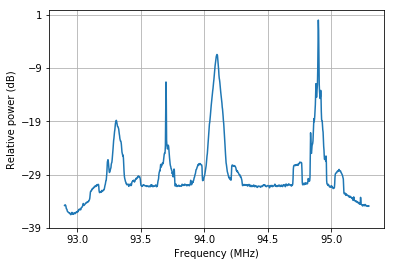

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

sample_rate = 2.4e6 
center_freq = 94.1e6

# use matplotlib to estimate and plot the PSD
plt.psd(samples, NFFT=1024, Fs=sample_rate/1e6, Fc=center_freq/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
plt.show()

As seen, there are multiple peaks in the power density plot. They are from different FM radio stations.

## 2. First-stage filtering and decimation

The first stage in demodulating an FM signal is to apply a decimation filter to it.

By "decimation filter" we mean the signal is first filtered and then decimated.

Decimation is just a fancy way of saying "downsampling", i.e., picking one sample from every N samples. We refer to N as "decimation factor".

---

We should apply a low-pass filter to filter out the FM signals whose carrier frequency is not 94.1 MHz. In other words, we select out the 94.1 MHz FM radio signal by applying a low-pass filter.

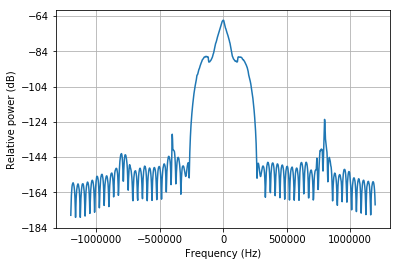

In [5]:
import scipy.signal as signal

# design a low-pass FIR filter with cutoff frequency 200KHz
lpf_b = signal.firwin(64, 200e3/(float(sample_rate)/2))
# filtering
samples_filtered_1 = signal.lfilter(lpf_b, 1, samples)

# use matplotlib to estimate and plot the PSD
plt.psd(samples_filtered_1, NFFT=1024, Fs=sample_rate, Fc=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power (dB)')
plt.show()

As shown in the power density plot, the unwanted bands are filtered out, leaving only the 94.1 MHz signals. 

The low-pass filter has other important functions which we will introduce later.

Next, we decimate (downsample) the signal by a factor of 10. This reduces the sample rate from 2.4M to 240k.

In [6]:
def downsample(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x) / M)) * M]
    x = x.reshape((int(np.floor(len(x) / M)), M))
    y = x[:,p]
    return y

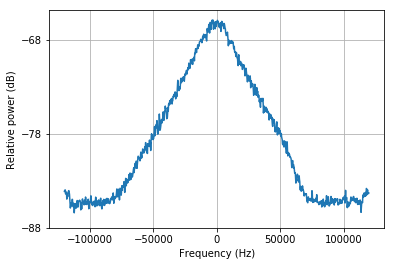

In [7]:
# decimate by a factor of 10
samples_decimated_1 = downsample(samples_filtered_1, 10)

# use matplotlib to estimate and plot the PSD
plt.psd(samples_decimated_1, NFFT=1024, Fs=sample_rate/10, Fc=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power (dB)')
plt.show()

The effect of decimation on the frequency domain is the x-axis being "expanded" (zoomed in).

# 3. Phase discrimination

Next, we can demodulate the FM signal by taking the derivative of its phase.

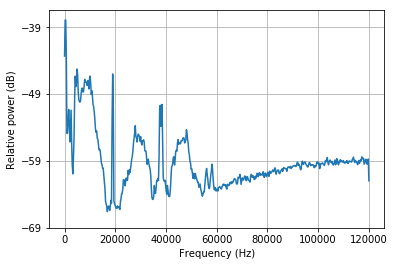

In [8]:
def fm_discrim(x):
    X = np.real(x)
    Y = np.imag(x)
    b = np.array([1, -1])
    dY = signal.lfilter(b,1,Y)
    dX = signal.lfilter(b,1,X)
    discriminated = (X * dY - Y * dX) / (X**2 + Y**2 + 1e-10)
    return discriminated

samples_discriminated = fm_discrim(samples_decimated_1)

# use matplotlib to estimate and plot the PSD
plt.psd(samples_discriminated, NFFT=1024, Fs=sample_rate/10, Fc=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power (dB)')
plt.show()

Note that the frequencies are positive now. This is because the demodulated signals are real. By contrast, the modulated signals are complex.

# 4. Second-stage filtering and decimation

The sample rate is 240k now, but the final audio sample rate should be 48k. So we still have to decimate by a factor of 5. 

Before decimation, you might want to filter out the higher frequency elements because this can avoid signals zoomed outside $\omega \in (-\pi, -\pi)$ being reflected back from $\omega = -\pi$ and $\omega = \pi$.

The frequency components being expanded outside $\omega = (-\pi, \pi)$ don't just disappear. Instead, they will get reflected back as if there are two "walls" at $\omega = -\pi$ and $\omega = \pi$. This is called **aliasing**. 

Therefore, before decimation, you always want to apply a low-pass filter. This is called an **anti-aliasing filter**. 

At the end of this notebook, we will see how the reflected-back signals can severely damage the audio quality when the parameters (`fc1`, `fc2`, `d1`, and `d2`) aren't appropriately chosen.

---

Now, let's apply an FIR filter with cutoff frequency 12kHz. We choose this number to make sure that the reflected-back frequency components are already filtered out (i.e., in the stop band) before decimation, so that they don't come back as significant unwanted noise after decimation.

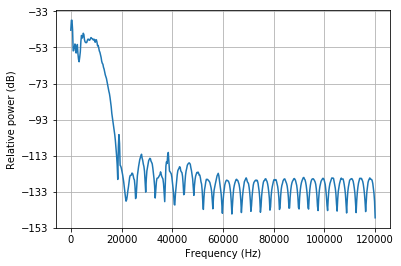

In [9]:
# design a low-pass FIR filter with cutoff frequency 12kHz
lpf_b = signal.firwin(64, 12e3/(float(sample_rate)/10/2))
# filtering
samples_filtered_2 = signal.lfilter(lpf_b, 1, samples_discriminated)

# use matplotlib to estimate and plot the PSD
plt.psd(samples_filtered_2, NFFT=1024, Fs=sample_rate/10, Fc=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power (dB)')
plt.show()

Next, we will decimate the signal by a factor of 5. 

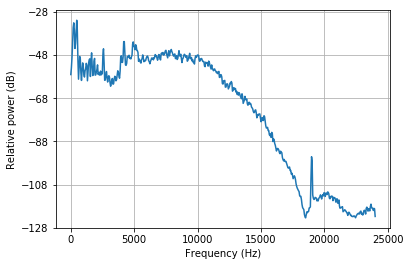

In [10]:
audio = downsample(samples_filtered_2, 5)

# use matplotlib to estimate and plot the PSD
plt.psd(audio, NFFT=1024, Fs=sample_rate/10/5, Fc=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative power (dB)')
plt.show()

Comparing the power density plots before and after the decimation, we can see that 12kHz is indeed a reasonable cutoff frequency:

1) The stop band starts at approximately 20000Hz, 

2) and the transition band is from 10000Hz to 20000Hz.

Frequencies above 10000Hz aren't really significant to human ears. As a reference, the frequency range of human voice is 300Hz---3400Hz.

Finally, let's play the final audio signal:

In [11]:
from IPython.display import Audio
Audio(audio, rate=48000)

# 5. Rewrite the codes into functions

Let's rewrite the whole demodulation process into a function for future convenience:

In [12]:
def fm_audio(samples, fs=2.4e6, fc=92.7e6, fc1=200e3, fc2=12e3, d1=10, d2=5, plot=False):
    lpf_b1 = signal.firwin(64, fc1/(float(fs)/2))
    lpf_b2 = signal.firwin(64, fc2/(float(fs)/d1/2))
    
    # 1st filtering
    samples_filtered_1 = signal.lfilter(lpf_b1, 1, samples)
    # 1st decimation
    samples_decimated_1 = downsample(samples_filtered_1, d1)
    # phase discrimination
    samples_discriminated = fm_discrim(samples_decimated_1)
    # 2nd filtering
    samples_filtered_2 = signal.lfilter(lpf_b2, 1, samples_discriminated)
    # 2nd decimation
    audio = downsample(samples_filtered_2, d2)
    
    if plot:
        fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(15, 10))

        ax0.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax0.set_title("samples")
        ax0.set_xlabel('Frequency (MHz)')
        ax0.set_ylabel('Relative power (dB)')
        
        ax1.psd(samples_filtered_1, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax1.set_title("samples_filtered_1")
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax2.psd(samples_decimated_1, NFFT=1024, Fs=fs/d1/1e6, Fc=fc/1e6)
        ax2.title.set_text('samples_decimated_1')
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax3.psd(samples_discriminated, NFFT=1024, Fs=fs/d1, Fc=0)
        ax3.title.set_text('samples_discriminated')

        ax4.psd(samples_filtered_2, NFFT=1024, Fs=fs/d1, Fc=0)
        ax4.title.set_text('samples_filtered_2')
        
        ax5.psd(audio, NFFT=1024, Fs=fs/d1/d2, Fc=0)
        ax5.title.set_text('audio')

        plt.show()
        
        return audio, fig, (ax0, ax1, ax2, ax3, ax4, ax5)
    else:
        return audio

Then, we can observe the power density plot of each signal at once:

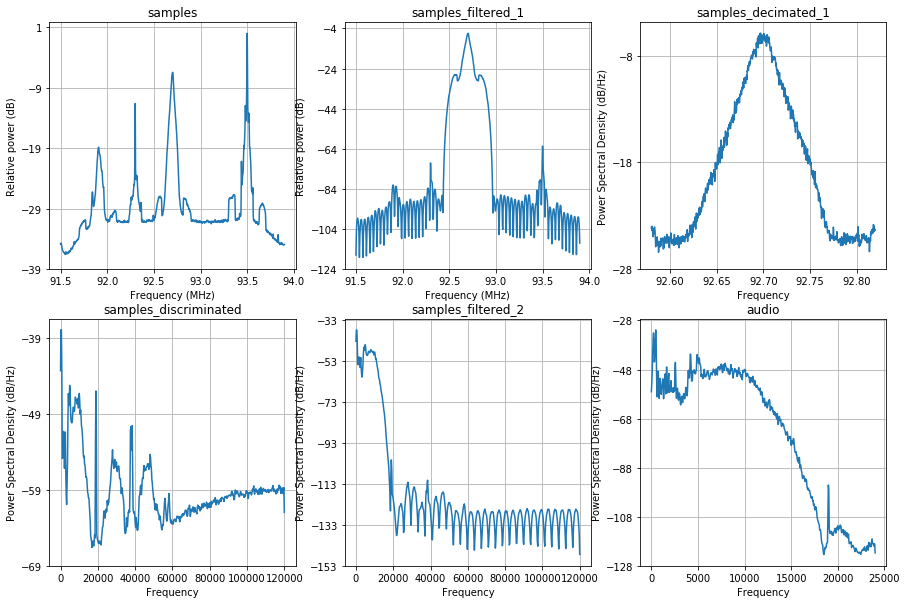

In [13]:
from IPython.display import Audio

audio, _, _ = fm_audio(samples, plot=True, fc1=200e3, fc2=12e3, d1=10, d2=5)
Audio(audio, rate=48000)

Finally, you can save the result to an audio file.

In [14]:
import sk_dsp_comm.sigsys as ss
ss.to_wav("audio.wav", 48000, audio)

# 6. Experimenting with decimation filter parameters

In this section, we will see how the "reflected" signals can severely add to the noise and damage the audio quality, which,
will remind us to carefully choose the cutoff frequency and decimation factor when designing a decimation filter.

In the following example, the cutoff frequency of the second filter (`fc2`) is inappropriately chosen. It is changed from 12e3 to 100e3.

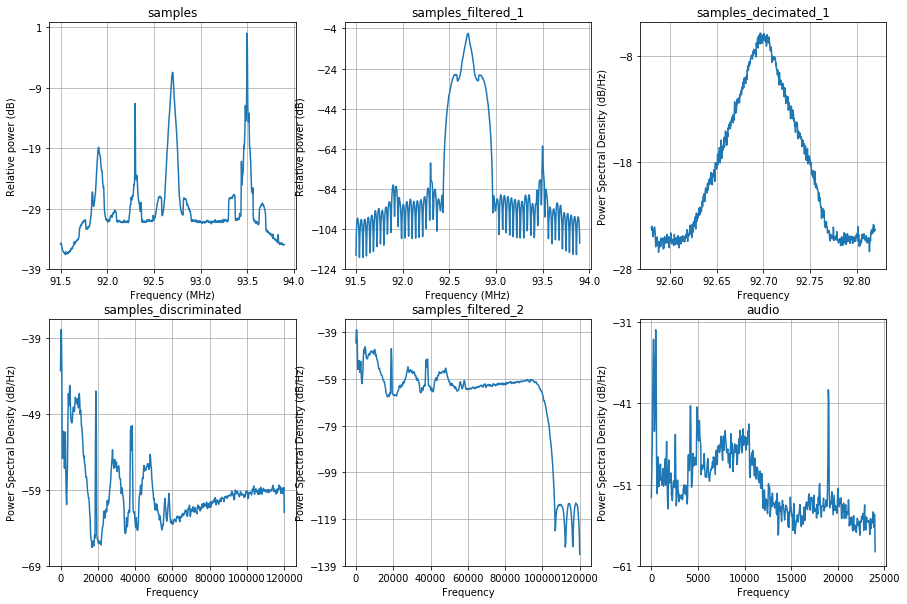

In [15]:
# you can experiment with the factors fc1, fc2, d1, and d2
# just make sure d1 * d2 = 2.4M/48000 = 50

# you can see how "reflected signals" can severely damage the audio quality
# by the following example, where fc2 is changed from 12e3 to 100e3

audio_25_2, _, _ = fm_audio(samples, plot=True, fc1=200e3, fc2=100e3, d1=10, d2=5)
Audio(audio_25_2, rate=48000)

In the above example, due to a large `fc2`, the frequency components zoomed outside $\omega \in (-\pi, \pi)$ are not completely filtered out in advance, and these components are reflected back from $\omega = -\pi$ and $\omega = \pi$, adding to the unwanted noise. You can hear the output audio to confirm that the audio quality is damaged.

---

Next, let's see an example with inapropriately chosen decimation factor. The decimation factor of the first-stage decimation filter (`d1`) is changed from 10 to 25.

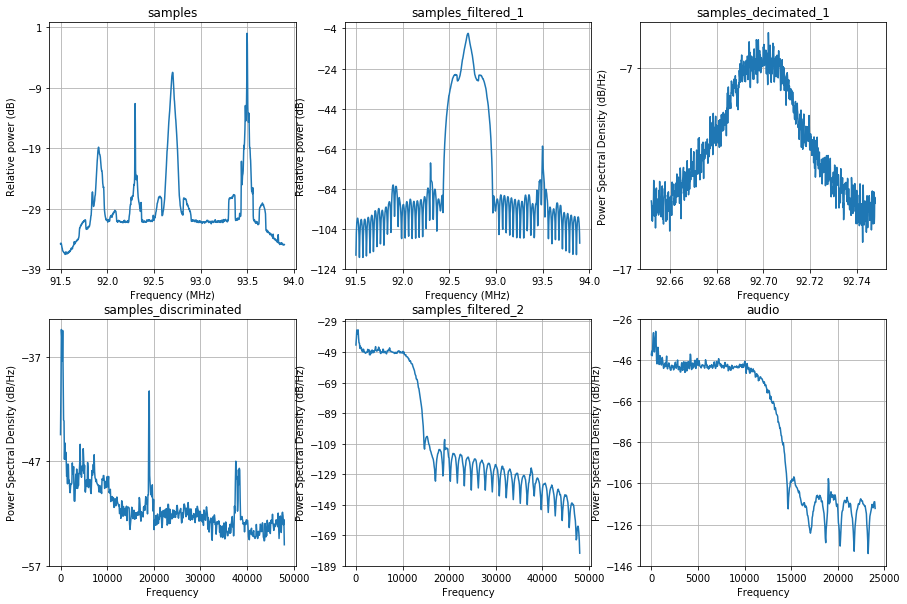

In [16]:
# you can experiment with the factors fc1, fc2, d1, and d2
# just make sure d1 * d2 = 2.4M/48000 = 50

# you can see how "reflected signals" can severely damage the audio quality
# by the following example, where d1 is changed from 10 to 25
# (Consequently, d2 is changed from 5 to 2)

audio_25_2, _, _ = fm_audio(samples, plot=True, fc1=200e3, fc2=12e3, d1=25, d2=2)
Audio(audio_25_2, rate=48000)

In the above example, due to a large `d1`, many unfiltered frequency components are zoomed outside $\omega \in (-\pi, \pi)$, and these components are reflected back from $\omega = -\pi$ and $\omega = \pi$, adding to the unwanted noise. You can hear the output audio to confirm that the audio quality is damaged.

# Conclusion

In this notebook, we have demonstrated how to demodulate an FM signal using prerecorded samples. Also, we have introduced how to choose the parameters (decimation factor and cutoff frequency) when designing a decimation filter.

In the next notebook, we will use AD9361 to receive FM signals in the air, and demodulate them using the functions developed in this notebook.

In the third notebook, we will deploy hardware demodulation, which is significantly faster than software demodulation and can therefore achieve real-time signal processing.

# Reference

The main reference of this notebook is [Parallel Programming for FPGAs](https://pp4fpgas.readthedocs.io/en/latest/project7.html), which is developed by [Kastner Research Group](https://github.com/KastnerRG).